# ML-IMC

In [76]:
using Dates
using Plots
using Statistics
using LinearAlgebra
using Distributed

if nworkers() == 1
    BLAS.set_num_threads(1)
    addprocs(4)
end

@everywhere begin
    include("src/distances.jl")
    include("src/readLJ.jl")
    include("src/ML-IMC.jl");
end

## 1. The first iteration

## 1.1. Input data 

In [2]:
bins, rdfref, histref = readRDF("rdf-mean-p40.dat")
histref ./= 500;

In [3]:
xyz = readXYZ("mctraj-p001.xyz")
conf = xyz[end]

parameters = readinput("LJML-init.in")

model = Dense(length(histref), 1, bias=true);

Reading mctraj-p001.xyz with 6012 lines...
Found 6 frames with 1000 atoms each...
Success! Closing the file...


In [4]:
η = 0.05; # learning rate

## 1.2. Running the simulation

In [5]:
function main(conf, parameters, model)    
    # Start the timer
    startTime = Dates.now()
    println("Running MC simulation on $(nworkers()) rank(s)...\n")
    println("Total number of steps: $(parameters.steps * nworkers() / 1E6)M")
    println("Starting at: ", startTime)
    
    # Prepare inputs
    input = conf, parameters, model
    inputs = [input for worker in workers()]
    
    # Run the simulation in parallel
    outputs = pmap(mcrun!, inputs)
    
    # Stop the timer
    stopTime = Dates.now()
    wallTime = Dates.canonicalize(stopTime - startTime)
    println("Stopping at: ", stopTime, "\n")
    println("Walltime: ", wallTime)
    
    return(outputs)
end;

In [6]:
outputs = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 8.0M
Starting at: 2022-03-28T17:16:36.686
      From worker 2:	Acceptance ratio = 0.3955815
      From worker 3:	Acceptance ratio = 0.395959
      From worker 4:	Acceptance ratio = 0.395441
      From worker 5:	Acceptance ratio = 0.3975325
Stopping at: 2022-03-28T17:18:20.584

Walltime: 1 minute, 43 seconds, 898 milliseconds


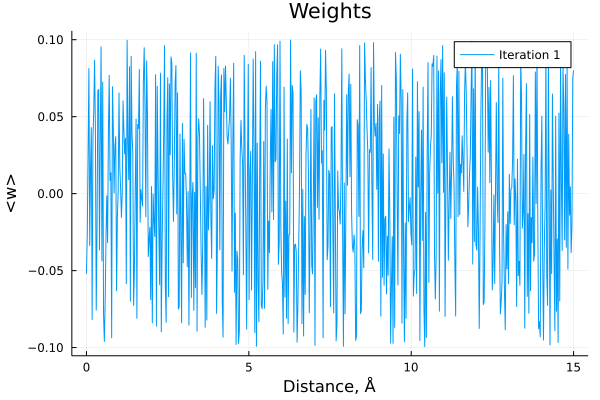

In [7]:
plot(bins, model.weight', title="Weights", label="Iteration 1")
xlabel!("Distance, Å")
ylabel!("<w>")

In [26]:
savemodel("model-iter-01.dat", model)

In [8]:
histNN = mean([output[1] for output in outputs]);

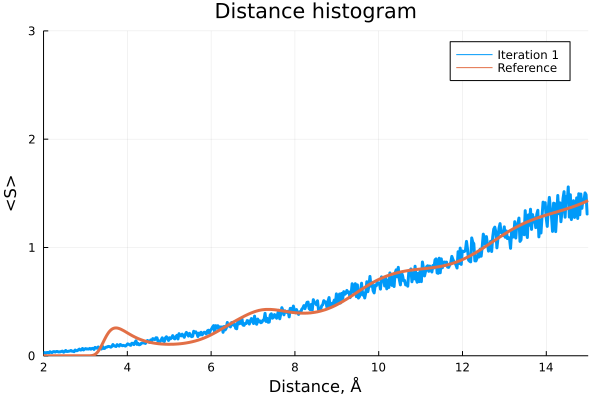

In [21]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 1", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [23]:
writehist("histNN-iter-01.dat", histNN, bins)

In [10]:
loss(histNN, histref);

Loss = 2.67871888


In [11]:
energies = mean([output[2] for output in outputs]);

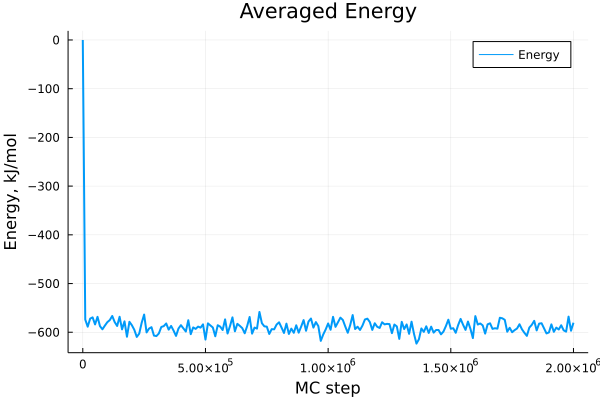

In [12]:
slicing = Int(1E1)
steps = 0:parameters.outfreq:parameters.steps
plot(steps[1:slicing:end], energies[1:slicing:end], lw=2, labels="Energy", title="Averaged Energy")
xlabel!("MC step")
ylabel!("Energy, kJ/mol")

In [13]:
crossWeights = mean([output[3] for output in outputs])
crossBiases = mean([output[4] for output in outputs]);

In [17]:
dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, model, parameters);

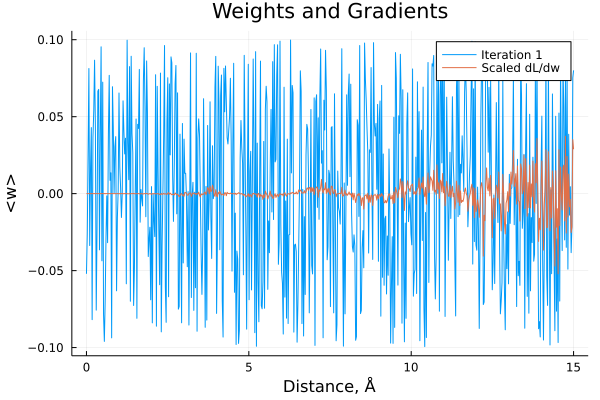

In [28]:
plot(bins, model.weight', title="Weights and Gradients", label="Iteration 1")
plot!(bins, dLdw*η, label="Scaled dL/dw")
xlabel!("Distance, Å")
ylabel!("<w>")

In [29]:
updatemodel!(model, η, dLdw, dLdb);

## 2. The second iteration

In [31]:
outputs_02 = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 8.0M
Starting at: 2022-03-28T17:36:24.164
      From worker 2:	Acceptance ratio = 0.4692995
      From worker 4:	Acceptance ratio = 0.468745
      From worker 3:	Acceptance ratio = 0.4697035
      From worker 5:	Acceptance ratio = 0.468863
Stopping at: 2022-03-28T17:37:35.857

Walltime: 1 minute, 11 seconds, 693 milliseconds


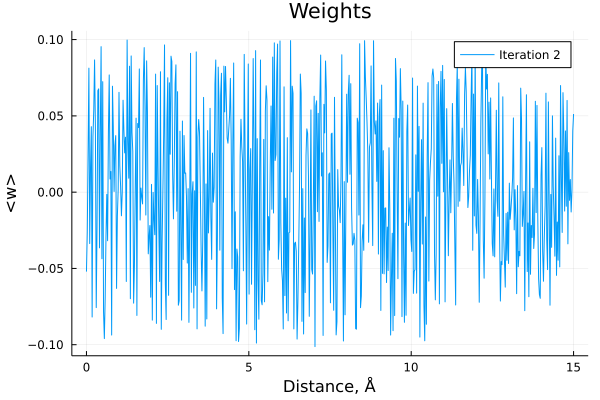

In [33]:
plot(bins, model.weight', title="Weights", label="Iteration 2")
xlabel!("Distance, Å")
ylabel!("<w>")

In [36]:
savemodel("model-iter-02.dat", model)

In [37]:
histNN = mean([output[1] for output in outputs_02]);

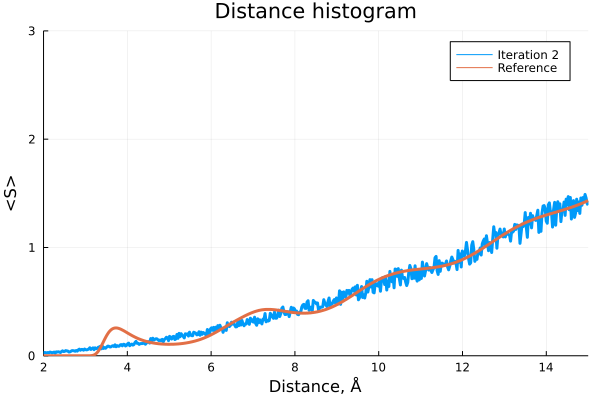

In [38]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 2", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [47]:
writehist("histNN-iter-02.dat", histNN, bins)

In [39]:
loss(histNN, histref);

Loss = 2.19989531


In [40]:
energies = mean([output[2] for output in outputs_02]);

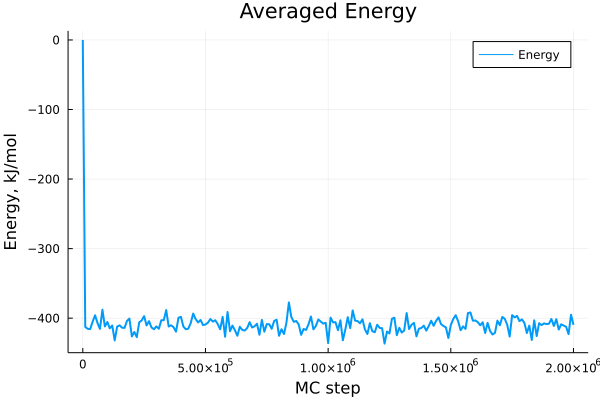

In [41]:
slicing = Int(1E1)
steps = 0:parameters.outfreq:parameters.steps
plot(steps[1:slicing:end], energies[1:slicing:end], lw=2, labels="Energy", title="Averaged Energy")
xlabel!("MC step")
ylabel!("Energy, kJ/mol")

In [42]:
crossWeights = mean([output[3] for output in outputs_02])
crossBiases = mean([output[4] for output in outputs_02]);

In [44]:
dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, model, parameters);

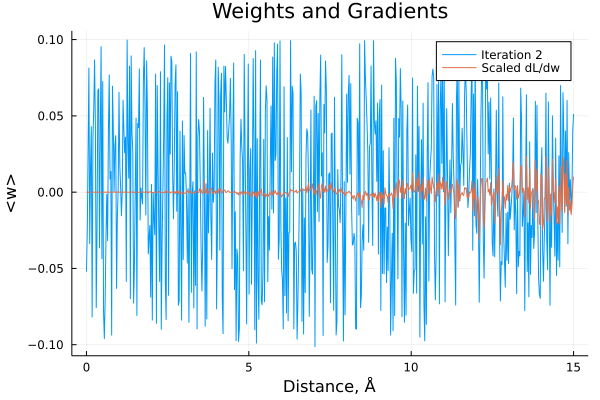

In [45]:
plot(bins, model.weight', title="Weights and Gradients", label="Iteration 2")
plot!(bins, dLdw*η, label="Scaled dL/dw")
xlabel!("Distance, Å")
ylabel!("<w>")

In [46]:
updatemodel!(model, η, dLdw, dLdb);

## 3. The third iteration

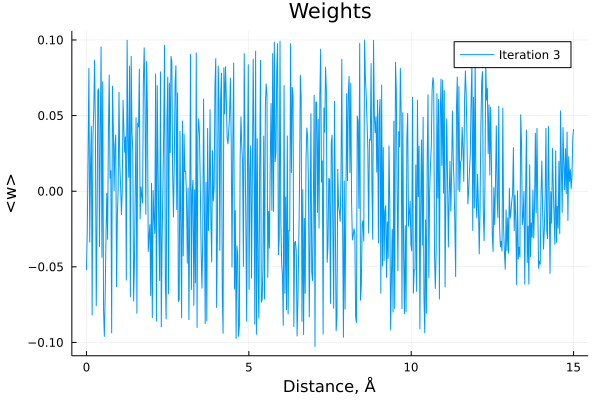

In [48]:
plot(bins, model.weight', title="Weights", label="Iteration 3")
xlabel!("Distance, Å")
ylabel!("<w>")

In [49]:
savemodel("model-iter-03.dat", model)

In [50]:
outputs_03 = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 8.0M
Starting at: 2022-03-28T17:44:24.457
      From worker 3:	Acceptance ratio = 0.5233115
      From worker 2:	Acceptance ratio = 0.521517
      From worker 5:	Acceptance ratio = 0.522459
      From worker 4:	Acceptance ratio = 0.5228065
Stopping at: 2022-03-28T17:45:36.910

Walltime: 1 minute, 12 seconds, 453 milliseconds


In [51]:
histNN = mean([output[1] for output in outputs_03]);

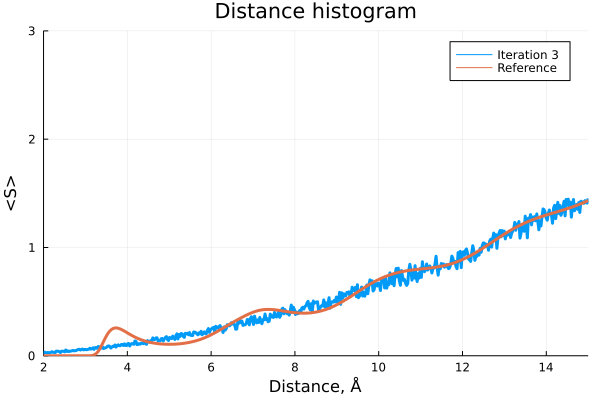

In [52]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 3", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [54]:
loss(histNN, histref);

Loss = 1.93079196


In [55]:
energies = mean([output[2] for output in outputs_03]);

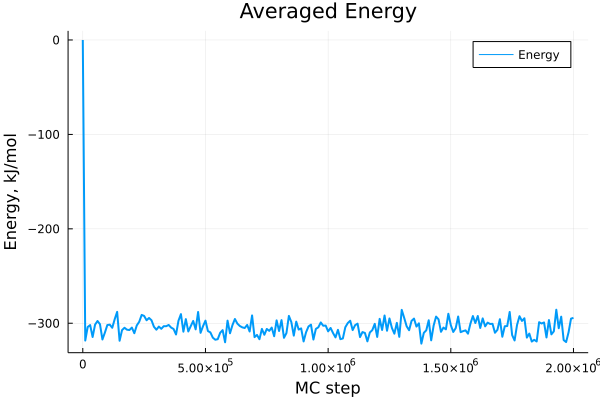

In [56]:
slicing = Int(1E1)
steps = 0:parameters.outfreq:parameters.steps
plot(steps[1:slicing:end], energies[1:slicing:end], lw=2, labels="Energy", title="Averaged Energy")
xlabel!("MC step")
ylabel!("Energy, kJ/mol")

In [57]:
crossWeights = mean([output[3] for output in outputs_03])
crossBiases = mean([output[4] for output in outputs_03]);

In [59]:
dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, model, parameters);

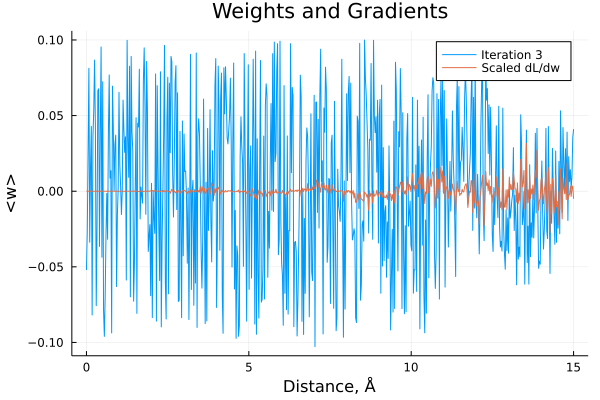

In [60]:
plot(bins, model.weight', title="Weights and Gradients", label="Iteration 3")
plot!(bins, dLdw*η, label="Scaled dL/dw")
xlabel!("Distance, Å")
ylabel!("<w>")

In [61]:
updatemodel!(model, η, dLdw, dLdb);

## 4. The fourth iteration

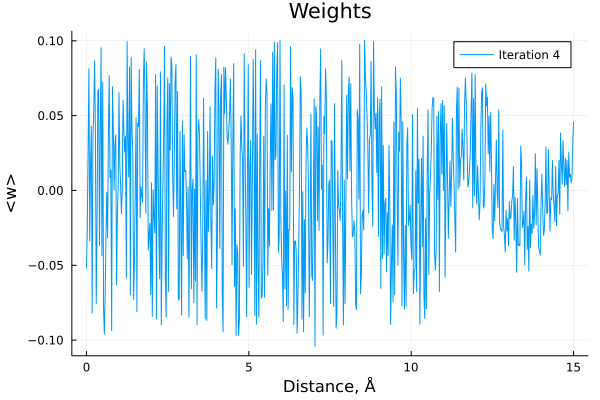

In [62]:
plot(bins, model.weight', title="Weights", label="Iteration 4")
xlabel!("Distance, Å")
ylabel!("<w>")

In [63]:
savemodel("model-iter-04.dat", model)

In [64]:
outputs_04 = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 8.0M
Starting at: 2022-03-28T17:49:16.329
      From worker 3:	Acceptance ratio = 0.563641
      From worker 2:	Acceptance ratio = 0.5626455
      From worker 4:	Acceptance ratio = 0.562521
      From worker 5:	Acceptance ratio = 0.563842
Stopping at: 2022-03-28T17:50:27.802

Walltime: 1 minute, 11 seconds, 473 milliseconds


In [65]:
histNN = mean([output[1] for output in outputs_04]);

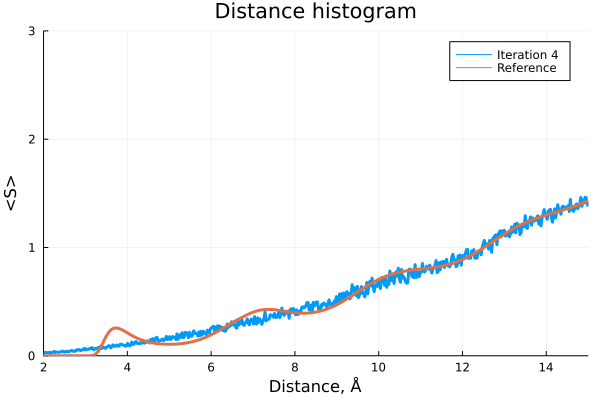

In [66]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Iteration 4", title="Distance histogram")
plot!(bins, histref, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("<S>")

In [68]:
loss(histNN, histref);

Loss = 1.69515722


In [69]:
energies = mean([output[2] for output in outputs_04]);

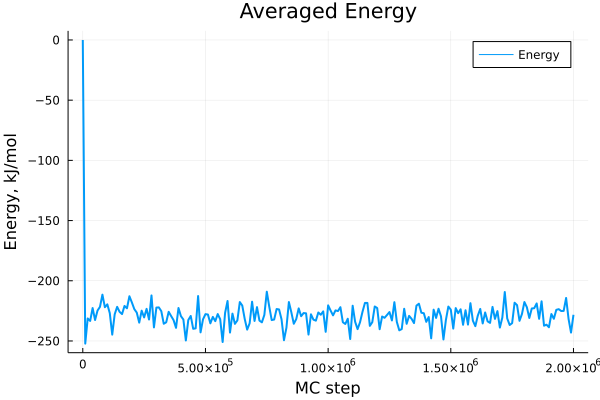

In [70]:
slicing = Int(1E1)
steps = 0:parameters.outfreq:parameters.steps
plot(steps[1:slicing:end], energies[1:slicing:end], lw=2, labels="Energy", title="Averaged Energy")
xlabel!("MC step")
ylabel!("Energy, kJ/mol")

In [71]:
crossWeights = mean([output[3] for output in outputs_04])
crossBiases = mean([output[4] for output in outputs_04]);

In [72]:
dLdw, dLdb = computeDerivatives(crossWeights, crossBiases, histNN, histref, model, parameters);

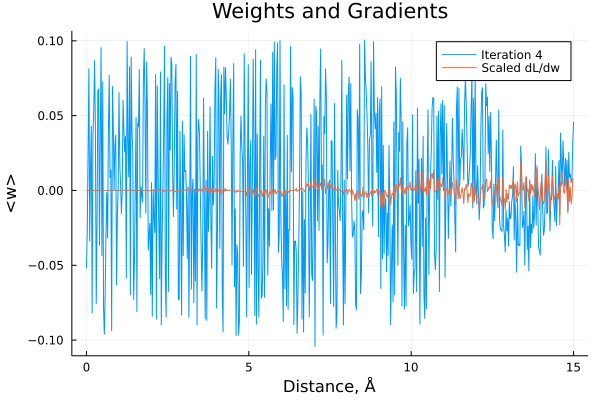

In [73]:
plot(bins, model.weight', title="Weights and Gradients", label="Iteration 4")
plot!(bins, dLdw*η, label="Scaled dL/dw")
xlabel!("Distance, Å")
ylabel!("<w>")

It's working! The loss function goes down. Now I'm going to run 10 iterations with the same settings.